# Nonlinear classifiers

## Load X,y data from NPZ

Using the function added to *mylib.py* file, it's now easy to grab data and X/y vectors ready to be used for model training and tuning

In [1]:
# Run content of mylib.py file
%run mylib.py

# Load data from NPZ file
(data, X, y)=loadXy(verbose=False)

## Random Tree Classifier

### Does increasing the number of trees help?

To answer this question, the best thing is, again, to use the GridSearchCV approach with different values for the *n_estimators* hyperparameter (this is the number of trees the classifier will use).

I've decided to use value from 1 to 100 (step=1) as values for my grid search.

I'll then graph the accuracy of the *train* and *test* sets obtained by the GridSearchCV fitting process.

> Note: I've added *max_depth* in my grid parameters, ans set it to *[None]*. I've made some tuning with it and finally decided to let it to None.


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Cross Validation K-Fold dimension
CV=5

# Create RandomClassifier object with default values
rfc = RandomForestClassifier(random_state=0)

# Set grid parameters for hyperparameters tuning
grid_param={
    'n_estimators': np.arange(1, 100, step=1),
    'max_depth': [None]
}

grid_rfc=GridSearchCV(rfc, grid_param, cv=CV, refit=True, return_train_score=True, verbose=True, n_jobs=-1, iid=True)

grid_rfc.fit(X['trainX'], y['trainX'])

best_estimator=grid_rfc.best_estimator_

accuracy_rfc=best_estimator.score(X['test'], y['test'])*100

print("\n")
print("RandomForestClassifier best estimator score : {:.1f}%".format(accuracy_rfc))


Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:   20.0s finished




RandomForestClassifier best estimator score : 92.2%


Let's display the best parameter we've found for n_estimator.

> Note: The sort is done in descending order on two columns, mean_test_score and std_test_score, to get the n_estimator value that fits best the mean and the standard deviation. If using only the mean as sorting column, the first line of the sort might not be the best estimator as the mean is identical for several n_estimator parameters.

In [3]:

columns=['param_n_estimators', 'param_max_depth', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']
results_df=pd.DataFrame(grid_rfc.cv_results_).sort_values(['mean_test_score', 'std_test_score'], ascending=False)[columns]

results_df.head()

,param_n_estimators,param_max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
44,45,None,0.923810,0.022638,0.999399,0.001201
83,84,None,0.923810,0.021136,1.000000,0.000000
86,87,None,0.923810,0.018769,1.000000,0.000000
58,59,None,0.923810,0.017590,1.000000,0.000000
95,96,None,0.921429,0.025623,1.000000,0.000000


It's now time to save our estimator with the best hyperparameter found: *n_estimator=45*

In [4]:
saveModel(best_estimator, 'random-forest')

Saving model random-forest to model-random-forest.sav


### So, does increasing the number of trees gives better results ?

Let's plot the *mean_train_score* and *mean_test_score* using my *plotGridSearchResults()* function from *mylib.py* library.

Parameters to this function has been set to display as well the standard deviation of those two metrics (*std_train_score* and *std_test_score*) with a factor of 50.

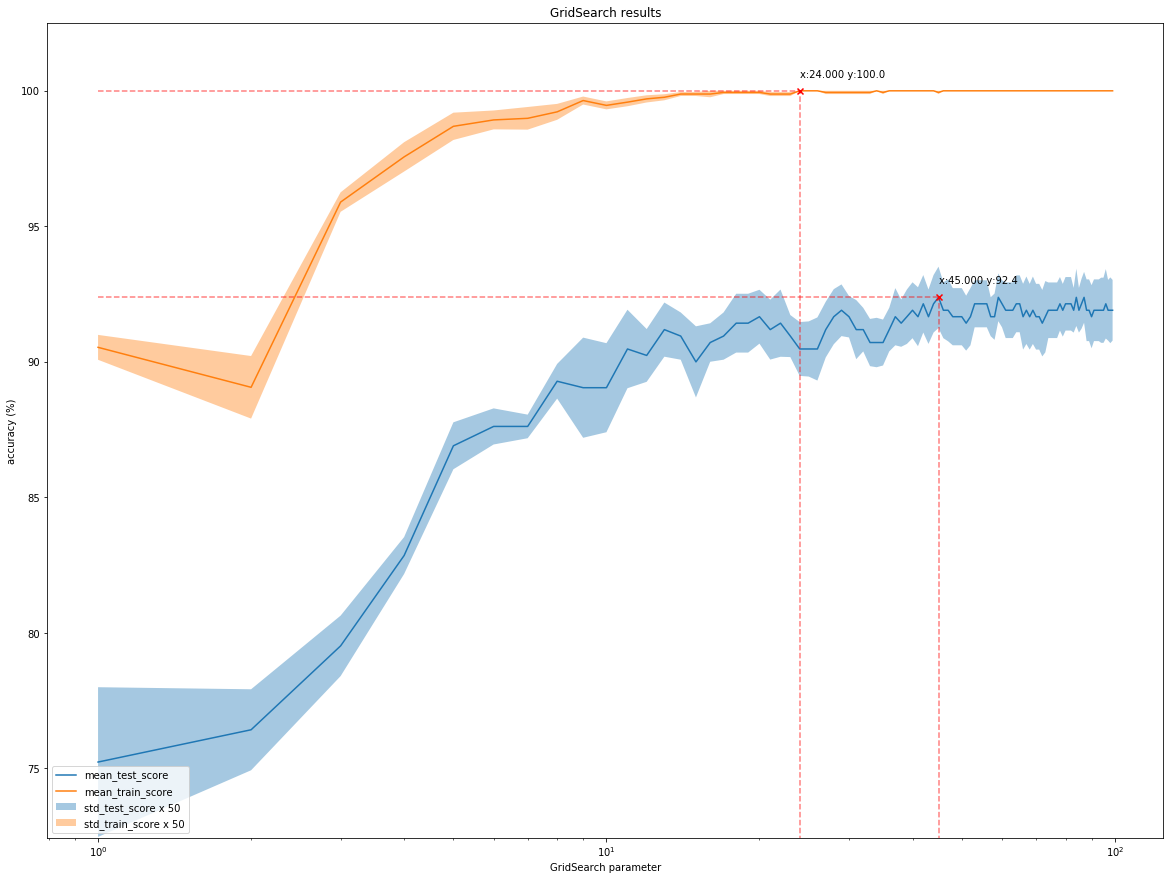

In [5]:
# Plot graph
plotGridSearchResults(results_df, 'param_n_estimators', ['mean_test_score', 'mean_train_score'], semilogx=True,
                      std_params={'mean_test_score': 'std_test_score','mean_train_score': 'std_train_score'},
                      std_factor=50, figsize=(20,15))

It clearly appears that increasing the number of trees gives better performance, and the optimum number is 81.

I can also conclude on the fact that the number of trees has a much lower effect on standard deviation.

### What about *max_depth* ?

I've set the max_depth parameter to *None*, according to the documentation, the classifier itself will determine the optimum value.

But, just for curiosity, does this parameter has any effect on the prediction score ?

Let's quickly draw the mean scores varying this parameter from 1 to 100 (step=1) with *n_estimators* fixed to 81

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:   31.4s finished




RandomForestClassifier best estimator score : 90.2%


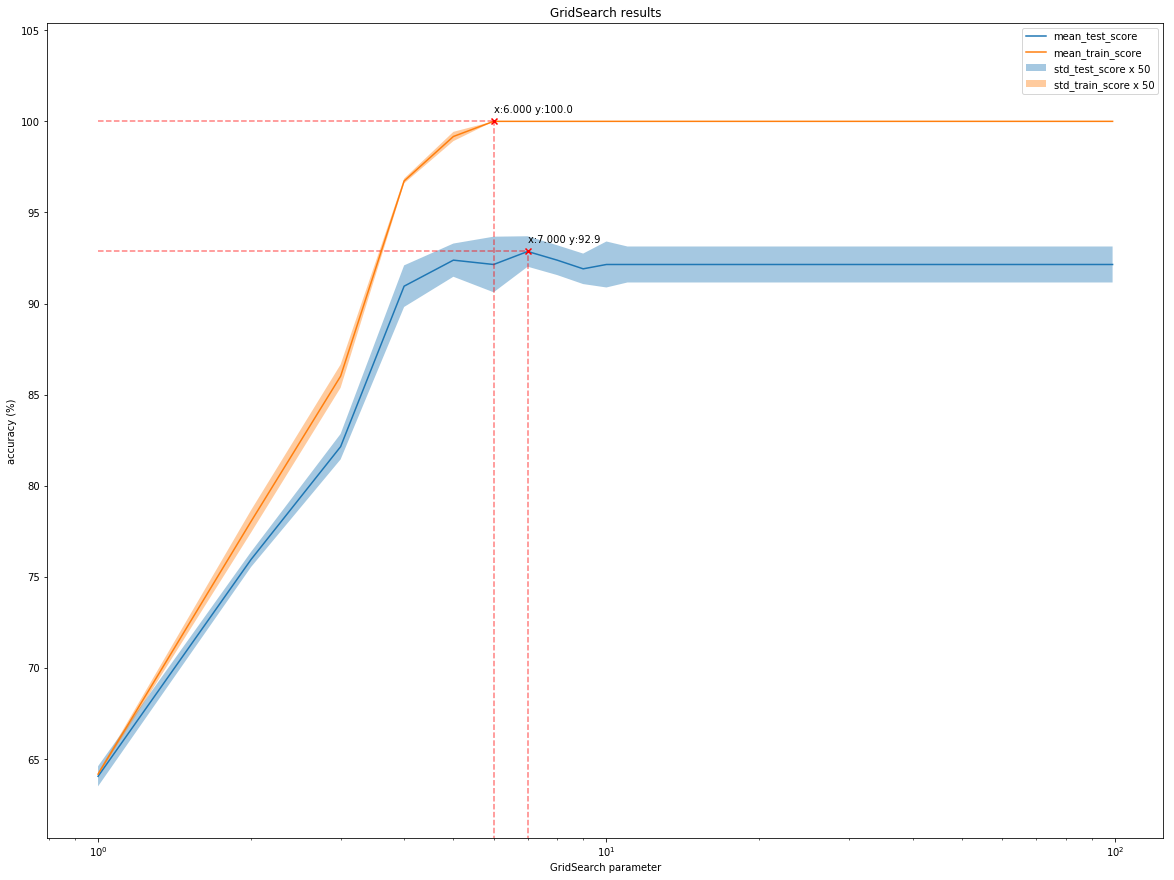

In [6]:
# Set grid parameters for hyperparameters tuning
grid_param={
    'n_estimators': [81],
    'max_depth': np.arange(1, 100, step=1),
}

grid_rfc=GridSearchCV(rfc, grid_param, cv=CV, refit=True, return_train_score=True, verbose=True, n_jobs=-1, iid=True)

grid_rfc.fit(X['trainX'], y['trainX'])

best_estimator=grid_rfc.best_estimator_

accuracy_rfc=best_estimator.score(X['test'], y['test'])*100

print("\n")
print("RandomForestClassifier best estimator score : {:.1f}%".format(accuracy_rfc))


results_df=pd.DataFrame(grid_rfc.cv_results_).sort_values(['mean_test_score', 'std_test_score'], ascending=False)
# Plot graph
plotGridSearchResults(results_df, 'param_max_depth', ['mean_test_score', 'mean_train_score'], semilogx=True,
                      std_params={'mean_test_score': 'std_test_score','mean_train_score': 'std_train_score'},
                      std_factor=50, figsize=(20,15))


Yes, *max_depth* is important in the sense that it must be set to a minimum value of 11 to not penalize the accuracy.

I had a look at the classifier documentation and found that default value for *max_depth* will be 100 in future release (10 actually). I would then suggest to keep the default 100.

Or, simplier, using *max_depth=None* do the job.

### Conclusion

Number of trees definitely determine the accuracy of our model, and performing a grid search on this parameter is a good idea.



## Support Vector Machine

### Does the RBF kernel perform better than the linear one?

To answer this question, I will use the *sklearn.svm.SVC* classifier and perform two grid search.

1. GridSearch with *kernel=linear*

This grid search will compute accuracy score using a linear SVM kernel and I will tune only one hyperparameter:

    * C, the regularization parameter

2. GridSearch with *kernel=rbf*

This grid search will use an 'rbf' SVM kernel and I will tune two parameters with it:

    * C, the regularization parameter
    * gamma, the kernel coefficient

Why not tuning the linear one with gamma ? Simply because it's not available ;-)

After the tuning is done, I will build global results dataframe that I'll used to graph, for each regularization parameters C, the accuracy scores I get with

    * The Linear SVM classifier
    * The different RBF SVM classifier, one for each gamma value used.

### Tune the Linear SVM classifier

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Create SVM with Linear kernel
svc_linear = SVC(kernel='linear')

# Cross Validation K-Fold dimension
CV=5

# Set grid parameters for regularization strenght tuning
# Not that for this first run, we do no tune this param, so I set it to default=1.0
grid_param={
    'C': np.logspace(-5, 1, num=50),
}

grid_linear=GridSearchCV(svc_linear, grid_param, cv=CV, refit=True, return_train_score=True, verbose=True, n_jobs=-1, iid=True)

grid_linear.fit(X['trainX'], y['trainX'])

columns=['param_C', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']
results_linear_df=pd.DataFrame(grid_linear.cv_results_).sort_values(['mean_test_score', 'std_test_score'], ascending=False)[columns]

results_linear_df.head()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   25.2s finished


,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
24,0.00868511,0.942857,0.012671,0.985726,0.002149
23,0.00655129,0.940476,0.015445,0.980371,0.004411
26,0.0152642,0.938095,0.018972,0.992864,0.004053
27,0.0202359,0.935714,0.022907,0.997024,0.002662
25,0.011514,0.935714,0.017737,0.989880,0.001460


#### Linear score on test dataset


In [8]:
# Get best accuracy score
best_linear=grid_linear.best_estimator_
accuracy_linear=best_linear.score(X['test'], y['test'])*100

print("LinearSVC score on test dataset : {:.1f}%".format(accuracy_linear))


LinearSVC score on test dataset : 96.1%


#### Save model


In [9]:
saveModel(best_linear, 'svm-linear')

Saving model svm-linear to model-svm-linear.sav


### Tune the RBF SVM classifier

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Create SVM with Linear kernel
svc_rbf = SVC(kernel='rbf')

# Cross Validation K-Fold dimension
CV=5

# Set grid parameters for regularization strenght tuning
# Not that for this first run, we do no tune this param, so I set it to default=1.0
grid_param={
    'C': np.logspace(-5, 1, num=50),
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

grid_rbf=GridSearchCV(svc_rbf, grid_param, cv=CV, refit=True, return_train_score=True, verbose=True, n_jobs=-1, iid=True)

grid_rbf.fit(X['trainX'], y['trainX'])

columns=['param_C', 'param_gamma', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']
results_rbf_df=pd.DataFrame(grid_rbf.cv_results_).sort_values(['mean_test_score', 'std_test_score'], ascending=False)[columns]

results_rbf_df.head()

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  3.7min finished


,param_C,param_gamma,mean_test_score,std_test_score,mean_train_score,std_train_score
283,5.68987,0.001,0.945238,0.021039,0.990470,0.002241
289,7.54312,0.001,0.942857,0.017830,0.992263,0.003049
271,3.23746,0.001,0.942857,0.012671,0.980969,0.004394
277,4.29193,0.001,0.942857,0.012671,0.985134,0.003183
295,10,0.001,0.938095,0.019165,0.997024,0.002662


#### Linear score on test dataset


In [11]:
# Get best accuracy score
best_rbf=grid_rbf.best_estimator_
accuracy_rbf=best_rbf.score(X['test'], y['test'])*100

print("SVM RBF score on test dataset : {:.1f}%".format(accuracy_linear))


SVM RBF score on test dataset : 96.1%


#### Save model


In [12]:
saveModel(best_rbf, 'svm-rbf')

Saving model svm-rbf to model-svm-rbf.sav


### Draw accuracy scores

In [13]:
all_df=results_linear_df.sort_values('param_C').copy()

for i in [0.001, 0.01, 0.1, 1, 10]:
    gamma_df=results_rbf_df[results_rbf_df['param_gamma'] == i].sort_values('param_C').copy()
    

all_df.head()



,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1e-05,0.235714,0.004853,0.23572,0.001213
1,1.32571e-05,0.235714,0.004853,0.23572,0.001213
2,1.75751e-05,0.235714,0.004853,0.23572,0.001213
3,2.32995e-05,0.235714,0.004853,0.23572,0.001213
4,3.08884e-05,0.235714,0.004853,0.23572,0.001213


### Conclusion